<a href="https://colab.research.google.com/github/afit-csce623-master/demos/blob/main/demo_multiclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This tutorial developed by W. Blair Watkinson II
# May 11, 2021

# Developed in support of education and research activities at 
# the Air Force Institute of Technology and the CSCE 623
# Machine Learning course

# For changes or questions, contact warren.watkinson@afit.edu

# Public Domain

# This is free and unencumbered software released into the public domain.

# Anyone is free to copy, modify, publish, use, compile, sell, or
# distribute this software, either in source code form or as a compiled
# binary, for any purpose, commercial or non-commercial, and by any
# means.

# In jurisdictions that recognize copyright laws, the author or authors
# of this software dedicate any and all copyright interest in the
# software to the public domain. We make this dedication for the benefit
# of the public at large and to the detriment of our heirs and
# successors. We intend this dedication to be an overt act of
# relinquishment in perpetuity of all present and future rights to this
# software under copyright law.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
# EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
# MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
# IN NO EVENT SHALL THE AUTHORS BE LIABLE FOR ANY CLAIM, DAMAGES OR
# OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE,
# ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
# OTHER DEALINGS IN THE SOFTWARE.

# For more information, please refer to <https://unlicense.org>

# Multiclass Image Classification with Feature Reduction

This tutorial provides an end-to-end example of a multi-classification of images using basic machine learning algorithms such as decision trees and support vector machines. We will demonstrate the use of feature reduction using principal component analysis (PCA) and histogram of oriented gradients (HOG).

We will use the CIFAR-10 dataset to explore our techniques.

## Download CIFAR-10 Dataset

The Keras machine learning API provides access to many datasets, including [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) and [MNIST](http://yann.lecun.com/exdb/mnist/). Both training images and test images are available with a simple function ([CIFAR-10](https://keras.io/api/datasets/cifar10/#load_data-function), [MNIST](https://keras.io/api/datasets/mnist/#load_data-function)). Below, we import the CIFAR-10 dataset into train and test sets.

In [2]:
DEBUG = False
K_FOLDS = 2
STEP_BY_STEP = False

from keras.datasets import cifar10
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


170500096/170498071 [==============================] - 6s 0us/step


## Examine CIFAR-10 Dataset

When we examine the shape of the CIFAR-10 dataset, we see that the train set includes 50000 images having a size of 32x32 with a 3-value RGB encoding for each pixel (the shape doesn't tell us precisely what the features mean, but the shape does confer the 50000, 32x32x3 relationship). The targets are single vector labels. The test set has 10000 samples.

In [3]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


Let's take a closer look at the type of data included in the train sets. When we examine the individual features, we note a 3-tuple of values in the range [0..255]. Also, target values are bound between [0..9].

In [4]:
import numpy as np

print(X_train[0])
print(y_train[0])
print(f'X_train range: {np.min(X_train)}..{np.max(X_train)}')
print(f'y_train range: {np.min(y_train)}..{np.max(y_train)}')

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[6]
X_train range: 0..255
y_train range: 0..9


When we examine the first image in the dataset, we see a relatively low resolution image of a frog.



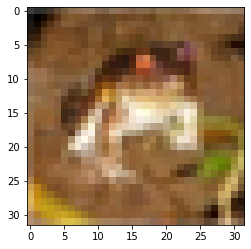

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])
plt.show()

It could be helpful to view sets of images as a time. We'll create a function that will display many images at a time. We'd like to label our images, but CIFAR-10 provides only numerical labels. An examination of the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) website provides the labels we need.

In [6]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can use the labels in a function that displays multiple images in a customizable grid.

In [7]:
# display images with labels in a nrows x ncols grid starting with the index image in the X dataset
def plot_figures(nrows, ncols, X, y, labels, cmap=None, start=0):
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*2 + (ncols-1)/2, nrows*2 + (nrows+1)/2))
    index = start
    for i in range(nrows):
        for j in range(ncols):
            axes[i,j].set_title(f'{index} {labels[y[index].item()]}')
            axes[i,j].imshow(X[index], cmap)
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            index += 1
    plt.show()

The above function iterates over the images in X displaying them in rows and columns. The title is provided as the image's index in the X array followed by the label (given by indexing the `labels` array with the `y` target value--as `y` is a 2d array, we need to grab the first and only element of the `y` row, so we use the `.item()` method.

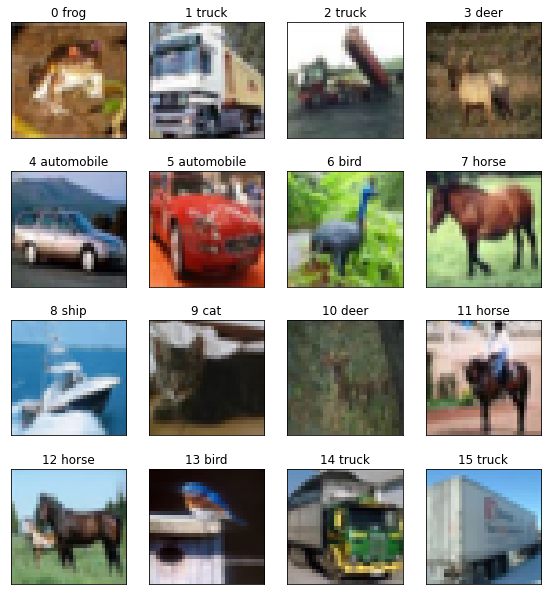

In [8]:
plot_figures(4, 4, X_train, y_train, labels)

## Transform Image Features for Input into ML Algorithms

In general, the feature structure of the `X_train` array will not work with machine learning algorithms. `X_train` is hallmarked by 50000 nested observations. That is, each observation is an a 32x32 array of 3 values. We instead need to ``unwrap'' each observation so that we have a row 32x32x3 features. We can do this by [reshaping](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) the array. Using a reshape value of -1 allows the function to infer the correct shape according to the lengths of each of the dimensions. The end result is an array 50000x3072 representing 50000 images each having 3072 features.

In [9]:
X_train_tf = X_train.reshape(X_train.shape[0], -1)
X_test_tf = X_test.reshape(X_test.shape[0], -1)

print(f'X_train_tf shape: {X_train_tf.shape}')

X_train_tf shape: (50000, 3072)


Another transformation to consider is normalizing all the RGB features to a value between [0..1]. Unlike the MinMaxScaler, we want to fix a value of 0 to zero and a value of 255 to 1. So, instead of using the MinMaxScaler, we will simply divide each of the features by 255.

In [10]:
X_train_tf = X_train_tf / 255.
X_test_tf = X_test_tf / 255.

print(f'X_train_tf range: {np.min(X_train_tf)}..{np.max(X_train_tf)}')

X_train_tf range: 0.0..1.0


There is no need to transform the target values. Unlike feature inputs, categorical values in the target do not need to be transformed to a one hot encoding scheme.

## Naive Classification

Let's try and use some basic classification techniques to see what we can come up with. To avoid overfitting, we'll use 5-fold cross-validation with stratification to ensure that we have a the target class of each fold has a similar ratio as the target class of the entire training set. Both tof these options are available by default in the `cross_val_score` function.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

if STEP_BY_STEP:
    accuracy = cross_val_score(DecisionTreeClassifier(), X_train_tf, y_train, cv=K_FOLDS)
    print(f'DTC accuracy: {np.mean(accuracy):.3f} (+/-{2*np.std(accuracy):.3f})')

    # accuracy = cross_val_score(SVC(degree=1), X_train_tf, y_train.ravel()) # SVC prefers 1d target array
    # print(f'SVC accuracy: {np.mean(accuracy):.3f} (+/-{2*np.std(accuracy)})')


## Feature Reduction

Let's look at three methods of feature reduction:
- Change color space to gray scale
- Histogram of Oriented gradients (HOG)
- Principal Component Analysis (PCA)

### Change to gray scale

The first feature reduction method will simply be to change from RGB scale to gray scale colors. This will reduce the feature space from 32x32x3 to 32x32.

The opencv-python library offers a convenient function `cvtColor` to convert colorspaces, with 274 different available conversions. The flag for converting from RGB to Gray is `cv2.COLOR_RGB2GRAY`. Note that the `cvtColor` function requires the original image feature structure, 32x32x3, and it will return observations of 32x32.

In [12]:
from cv2 import cvtColor, COLOR_RGB2GRAY

if STEP_BY_STEP:
    X_train_gray = np.array([cvtColor(image, COLOR_RGB2GRAY) for image in X_train])
    X_test_gray = np.array([cvtColor(image, COLOR_RGB2GRAY) for image in X_test])

    print(f'X_train_fray shape: {X_train_gray.shape}')
    print(X_train_gray[0])

We need to transform the values into [0..255] range:

In [13]:
if STEP_BY_STEP:
    X_train_gray_tf = X_train_gray.reshape(X_train_gray.shape[0], -1)
    X_train_gray_tf = X_train_gray_tf / 255.

    X_test_gray_tf = X_test_gray.reshape(X_test_gray.shape[0], -1)
    X_test_gray_tf = X_test_gray_tf / 255.

In [14]:
if STEP_BY_STEP:
    accuracy = cross_val_score(DecisionTreeClassifier(), X_train_gray_tf, y_train, cv=K_FOLDS)
    print(f'DTC accuracy: {np.mean(accuracy):.3f} (+/-{2*np.std(accuracy):.3f})')

    # accuracy = cross_val_score(SVC(degree=1), X_train_gray_tf, y_train.ravel()) # SVC prefers 1d target array
    # print(f'SVC accuracy: {np.mean(accuracy):.3f} (+/-{2*np.std(accuracy)})')

### Histogram of Orientated Gradients

For an overview of of HOG, consider [this Python Code tutorial](https://www.thepythoncode.com/article/hog-feature-extraction-in-python). If you do use HOG in your research, consider referencing [Dalal & Triggs 2005 paper](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf). A visualization of HOG applied to a high-quality image is available in the [scikit-image docs](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).

The HOG algorithm is applied to the frog image below. In this example, we use a cell size of 4x4 with 2x2 cells per block. This means that the 4x4 filter will step across the image 2 pixels at time. As the image is 32x32, the 4x4 filter, starting in the top left corner, will take 14 steps across and 14 steps down the image, creating 9 features at each step. Consequently, the 32x32x3 = 3072 feature space will be reduced to 14x14x9 = 1764.


(32, 32, 3)


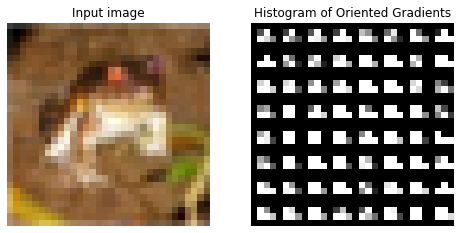

(1764,)


In [15]:
from skimage.feature import hog
from skimage import data, exposure

# image = data.astronaut()
image=X_train[0]
print(image.shape)
fd, hog_image = hog(image, orientations=9, pixels_per_cell=(4,4), cells_per_block=(2,2), visualize=True, multichannel=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)


ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

print(fd.shape)

In [16]:
if STEP_BY_STEP:
    X_train_hog = np.array([hog(image, 
                                orientations=9, 
                                pixels_per_cell=(4,4), 
                                cells_per_block=(2,2), 
                                visualize=False, 
                                multichannel=True) for image in X_train])
    X_test_hog = np.array([hog(image, 
                            orientations=9, 
                            pixels_per_cell=(4,4), 
                            cells_per_block=(2,2), 
                            visualize=False, 
                            multichannel=True) for image in X_test])
    print(X_train_hog.shape)
    print(X_test_hog.shape)

In [17]:
if STEP_BY_STEP:
    accuracy = cross_val_score(DecisionTreeClassifier(), X_train_hog, y_train, cv=K_FOLDS)
    print(f'DTC accuracy: {np.mean(accuracy):.3f} (+/-{2*np.std(accuracy):.3f})')

    # accuracy = cross_val_score(SVC(degree=1), X_train_gray_tf, y_train.ravel()) # SVC prefers 1d target array
    # print(f'SVC accuracy: {np.mean(accuracy):.3f} (+/-{2*np.std(accuracy)})')

### Principal Component Analysis

Principal component analysis (PCA) is a technique to identify the combinations of features that explain the variance in a feature set to create a low-dimensional feature space. See _ISLR_ pages 374-376 for additional details. In the example below, we use the scikit-learn PCA function to find a transform from the X feature space to X' where the amount of variance explained by the features in X' is at least 70%.

In [18]:
from sklearn.decomposition import PCA

if STEP_BY_STEP:
    pca = PCA(.7) # can also use an integer to specify a number of features. 
    X_train_pca = pca.fit_transform(X_train_tf)
    X_test_pca = pca.transform(X_test_tf)

In [19]:
if STEP_BY_STEP:
    accuracy = cross_val_score(DecisionTreeClassifier(), X_train_pca, y_train, cv=K_FOLDS)
    print(f'DTC accuracy: {np.mean(accuracy):.3f} (+/-{2*np.std(accuracy):.3f})')

    # accuracy = cross_val_score(SVC(degree=1), X_train_gray_tf, y_train.ravel()) # SVC prefers 1d target array
    # print(f'SVC accuracy: {np.mean(accuracy):.3f} (+/-{2*np.std(accuracy)})')

## One pipeline to rule them all

In this section, we will repeat the above steps in order that we can combine all of them in a single pipeline. Doing this will allow us to use the pipeline to conduct a gridsearch over hyperparameters. A pipeline step requires an estimator that implements fit and transform.

### Flatten and Normalize image


The following class will flatten and normalize observations

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class FlattenImages(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reshape(X.shape[0], -1) / 255.

### Recolor Image


The following class will recolor observations

In [21]:
import cv2

class RecolorImages(TransformerMixin, BaseEstimator):
    def __init__(self, color=cv2.COLOR_RGB2GRAY):
        self.color = color

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([cv2.cvtColor(image, self.color) for image in X])


### HOG Image

The following class will transform observations using HOG

In [22]:
class HOGImages(TransformerMixin, BaseEstimator):
    def __init__(self, skip=True, orientations=9, pixels_per_cell=8, cells_per_block=4, multichannel=True):
        self.skip = skip
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.multichannel = multichannel

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        if self.skip:

            return X
        else:

            new_X = np.array([hog(image, 
                                orientations=self.orientations, 
                                pixels_per_cell=(self.pixels_per_cell,self.pixels_per_cell), 
                                cells_per_block=(self.cells_per_block,self.cells_per_block), 
                                visualize=False, 
                                multichannel=self.multichannel) for image in X])
            return new_X


### PCA Image

The following class will apply PCA unless n_components is None

In [23]:
# class PCAImages(TransformerMixin, BaseEstimator):
#     def __init__(self, n_components = None):
#         self.n_components = n_components
#         # if n_components is not None:
#         #     self.pca = PCA(n_components)
#         # else:
#         #     self.pca = None

#     def fit(self, X, y=None):
#         if self.n_components is not None:
#             pca = PCA(n_components)

#         print(self.n_components)
#         if self.n_components is not None:
#             return pca.fit(X, y)
#         return self
    
#     def transform(self, X, y=None):
#         if self.n_components is not None:
#             return self.pca.transform(X, y)    
#         else:
#             return X

### Pipeline

Transforming/fitting each of the features is time-consuming. We can save time by storing those transformations for reuse. We can  

In [24]:
import string

letters = list(string.ascii_lowercase)

# there is a theoretical possibility of overwriting your cache
# if notebooks are in the same folder and have the same seed value
rng = np.random.default_rng(seed = 42) 

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    cache_store = '/content/drive/MyDrive/search_cache_multiclassification_' + ''.join(rng.choice(letters) for i in range(10))
else:
    cache_store = 'search_cache_' + ''.join(rng.choice(letters) for i in range(10))

Mounted at /content/drive


In [25]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('recolor', RecolorImages()),
    ('hog', HOGImages()),
    ('flatten', FlattenImages()),
    ('pca', PCA()),
    ('dtc', DecisionTreeClassifier())     
], memory=cache_store)

In [26]:
param_grid = [
    # RGB
    {
        'recolor': ['passthrough'],
        'hog__skip': [True, False],
        'hog__multichannel': [True],
        'hog__pixels_per_cell': [4, 8], #, 16],
        'hog__cells_per_block': [1, 2], #, 3],
        'hog__orientations': [4, 9],
        'pca': ['passthrough', PCA(0.7), PCA(0.8), PCA(0.9), PCA(0.95), PCA(0.99)],
        # 'dtc__max_depth': [1]
    },
    # grayscale
    {
        'recolor__color': [cv2.COLOR_RGB2GRAY], #['passthrough'], #,
        'hog__skip': [True, False],
        'hog__multichannel': [False],
        'hog__pixels_per_cell': [4, 8], #, 16],
        'hog__cells_per_block': [1, 2], #, 3],
        'hog__orientations': [4, 9],
        'pca': ['passthrough', PCA(0.7), PCA(0.8), PCA(0.9), PCA(0.95), PCA(0.99)],
        # 'dtc__max_depth': [1]
    }
]

param_grid = {
        'recolor': ['passthrough'],
        'hog__skip': [False],
        'hog__multichannel': [True],
        'hog__pixels_per_cell': [6,8], #, 16],
        'hog__cells_per_block': [2, 3], #, 3],
        'hog__orientations': [9],
        'pca': [PCA(0.5), PCA(0.55), PCA(0.6), PCA(0.65)],
        'dtc__max_depth': [9, 10, 11],
}              


In [27]:
from sklearn.model_selection import GridSearchCV
import warnings

grid_search = GridSearchCV(pipeline, param_grid, n_jobs=1, verbose=4, cv=K_FOLDS)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough, score=0.341, total= 1.0min
[CV] dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough, score=0.345, total=  56.7s
[CV] dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.55, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV]  dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.55, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough, score=0.342, total=  30.3s
[CV] dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.55, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[CV]  dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.55, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough, score=0.344, total=  30.6s
[CV] dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough 
[CV]  dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels_per_cell=6, hog__skip=False, pca=PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), recolor=passthrough, score=0.342, total=  30.8s
[CV] dtc__max_depth=9, hog__cells_per_block=2, hog__multichannel=True, hog__orientations=9, hog__pixels

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 38.5min finished


In [28]:
def display_search_results(grid_search):
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
                % (mean, std * 2, params))

    best_loc = np.nanargmax(means)
    print(f'Best: {means[best_loc]:.3f} (+/-{stds[best_loc] * 2:.3f}) for {grid_search.cv_results_["params"][best_loc]}')

In [29]:
display_search_results(grid_search)

0.343 (+/-0.005) for {'dtc__max_depth': 9, 'hog__cells_per_block': 2, 'hog__multichannel': True, 'hog__orientations': 9, 'hog__pixels_per_cell': 6, 'hog__skip': False, 'pca': PCA(copy=True, iterated_power='auto', n_components=0.5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'recolor': 'passthrough'}
0.343 (+/-0.002) for {'dtc__max_depth': 9, 'hog__cells_per_block': 2, 'hog__multichannel': True, 'hog__orientations': 9, 'hog__pixels_per_cell': 6, 'hog__skip': False, 'pca': PCA(copy=True, iterated_power='auto', n_components=0.55, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'recolor': 'passthrough'}
0.342 (+/-0.000) for {'dtc__max_depth': 9, 'hog__cells_per_block': 2, 'hog__multichannel': True, 'hog__orientations': 9, 'hog__pixels_per_cell': 6, 'hog__skip': False, 'pca': PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'recolor': 'passthrough'}
0.342 (+/-0.001) for {'dtc__ma

In [30]:
y_train_pred = grid_search.predict(X_train)

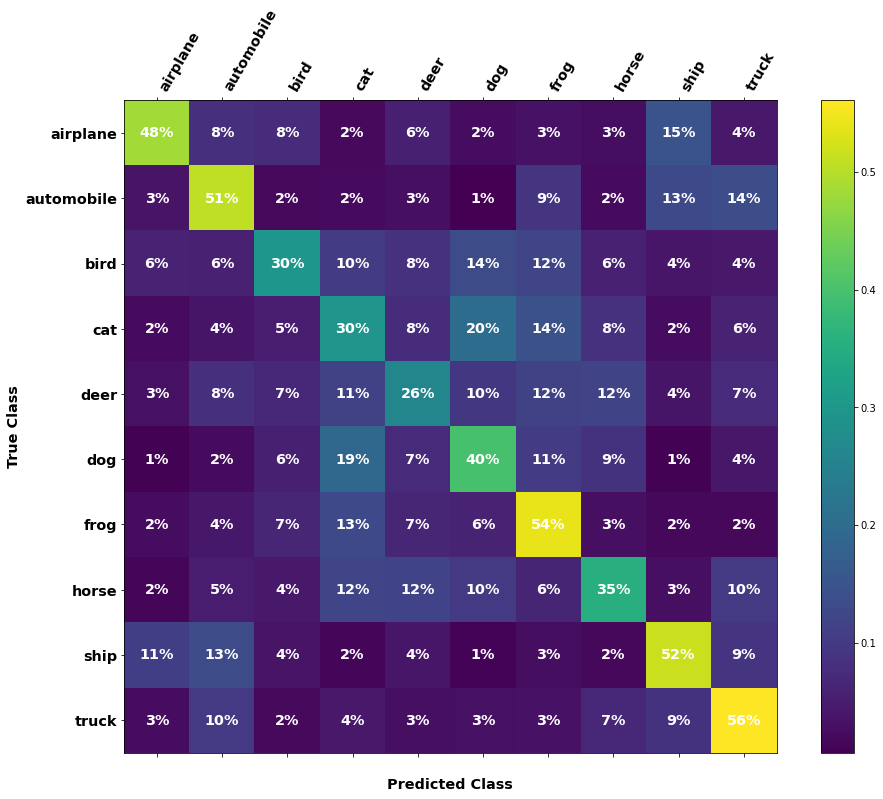

In [31]:
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

conf_mx = confusion_matrix(y_train, y_train_pred)
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums #np.max(conf_mx) #row_sums

figure = plt.figure(figsize=(16, 12))
axes = figure.add_subplot(111)

caxes = axes.matshow(norm_conf_mx) #cmap=plt.cm.gray)
figure.colorbar(caxes)


axes.set_xticklabels(labels, rotation=60, ha='left', fontsize='x-large', fontweight='bold')
axes.set_yticklabels(labels, fontsize='x-large', fontweight='bold')
axes.set_xticks(np.arange(len(labels)))
axes.set_yticks(np.arange(len(labels)))

axes.set_xlabel('Predicted Class', fontsize='x-large', fontweight='bold', labelpad=25)
axes.set_ylabel('True Class', fontsize='x-large', fontweight='bold')

for (row, col), z in np.ndenumerate(norm_conf_mx):
    axes.text(col, row, '{:.0%}'.format(z), ha='center', va='center', color=[1,1,1], fontsize='x-large', fontweight='bold')

plt.show()